# Early Stopping Of Stochastic Gradient Descent

In this notebook I will demonstrate early stopping of Stochastic Gradient Descent.

In [57]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml

I will use the popular [mnist_784](https://www.openml.org/d/554) dataset for the purpose of this notebook. It is a database of handwritten digits with 784 features and the goal is to provide the correct class for each image.

In [121]:
# Fetch mnist data
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)

To make this task a binary classification problem (and therefore even simpler), we will filter the dataset to the digits `0` and `5`. And our goal is to predict for each digit whether it is a `5` or not.

In [122]:
# Filter the dataset and recreate label
filter_mask = np.isin(y, ['0', '5'])
X, y = X[filter_mask], y[filter_mask]
y = np.where(y == '5', 1, 0)

Let's take a look on some  samples.

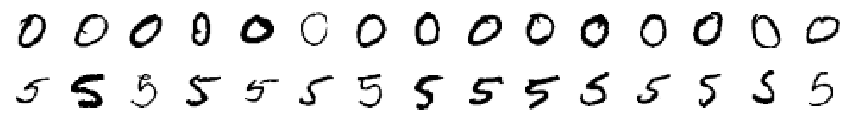

In [133]:
# Draw random samples for each class
sample0_idx = np.random.choice(np.argwhere(y==0).squeeze(), 15)
sample5_idx = np.random.choice(np.argwhere(y==1).squeeze(), 15)

fig = plt.figure(figsize=(15, 2))
for i, idx in enumerate(np.r_[sample0_idx, sample5_idx]):
    ax = fig.add_subplot(2, 15, i+1)
    ax.imshow(X[idx].reshape(28, 28), cmap='Greys') # Reshape before plotting
    ax.set_axis_off()
plt.show()

In [ ]:
#
